In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**AIML Capstone Project - Interim Report**
**Project - Computer Vision: Object Detection - Car**

*Team Members:* 
- Gobinath Subramani
- Hitesh Umaletiya
- Anupam Kundu
- Manoj Bhardwaj

ABSTRACT -  In the domain of automotive surveillance, Computer Vision can be used to automate supervision and generate appropriate action if the trigger event is predicted from the image of interest. For example, an image of a car moving on the road taken by a camera can be used to identify the make of the car, type, color, number plates, etc.

The objective of this project is to design a car identification model based on Deep Learning techniques. The Stanford Car Dataset is used here which contains 16,185 images of 196 different classes of cars. The data is split into 8,144 training images and 8,041 testing images where each class has been roughly split in a 50-50 split. Apart from the training and testing images with labels of make and year of the cars, the dataset also contains annotations for the bounding boxes for the images.

In our study we have initially modeled CNNs with MobileNet, VGGNet and ResNet for bounding box regression analysis and classification of the vehicles with encouraging results. In the initial training attempts, we found VGGNet to perform better for the classification problem. Fine-tuning the models will improve the results further.



**Import Libraries**

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import cv2 as cv
import random
import csv
from PIL import Image

import tensorflow
from tensorflow.keras.applications import VGG16,MobileNet
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization,Conv2D,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, initializers

**Importing Data**

In [ ]:
path_base = "/content/drive/My Drive/Colab Notebooks"

In [ ]:
class_names = []

with open(path_base+'/names.csv') as csvDataFile:
    csvReader = csv.reader(csvDataFile, delimiter=';')
    for row in csvReader:
        class_names.append(row[0])

print(class_names[195])

smart fortwo Convertible 2012


In [ ]:
datapath = path_base+"/car_data/car_data"

In [ ]:
train_dir = datapath+"/train"
test_dir = datapath+"/test"

In [ ]:
car_names_train = {}

for i in os.listdir(train_dir):
     car_names_train[i] = os.listdir(train_dir + '/' + i)

In [ ]:
car_images_ls = []
car_names_ls = []
car_classes = []
car_directories = []

for i in car_names_train:
    car_classes.append(i)

for i,j in enumerate(car_names_train.values()):
    for img in j:
        car_images_ls.append(img)
        car_names_ls.append(car_classes[i])
        
for i in range(len(car_names_ls)):
    car_directories.append(train_dir + '/' + car_names_ls[i] + '/' + car_images_ls[i])

**Checking Random Sample**

Text(0.5, 1.0, 'Audi V8 Sedan 1994')

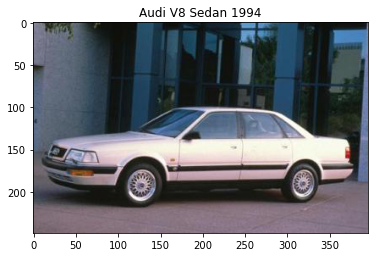

In [ ]:
plt.imshow(Image.open(car_directories[1001]))
plt.title(car_names_ls[1001])

In [ ]:
anno_train = path_base+"/anno_train.csv";
anno_test = path_base+"/anno_test.csv";

**Pre-Processing Data**

In [ ]:
IMAGE_SIZE = 128

In [ ]:
with open(anno_train, "r") as f:
  
  y_train = np.zeros((sum(1 for line in f), 4))
  X_train = []
  f.seek(0)
  data = csv.reader(f, delimiter=',')
  for index, row in enumerate(data):
    for i, r in enumerate(row[1:7]):
      row[i+1] = int(r)
    path, x0, y0,x1,y1, carclass = row
    path = train_dir +'/' +class_names[carclass-1]+ "/" + path

    im = Image.open(path)
    image_width, image_height = im.size

    
    y_train[index, 0] = x0 * IMAGE_SIZE / image_width            
    y_train[index, 1] = y0 * IMAGE_SIZE / image_height            
    y_train[index, 2] = (x1-x0) * IMAGE_SIZE / image_width       
    y_train[index, 3] = (y1-y0) * IMAGE_SIZE / image_height      
    
    X_train.append(path)  

In [ ]:
with open(anno_test, "r") as f:
  
  y_test = np.zeros((sum(1 for line in f), 4))
  X_test = []
  f.seek(0)
  data = csv.reader(f, delimiter=',')
  for index, row in enumerate(data):
    for i, r in enumerate(row[1:7]):
      row[i+1] = int(r)
    path, x0, y0,x1,y1, carclass = row
    path = test_dir + '/' +class_names[carclass-1]+ "/" + path
    
    im = Image.open(path)
    image_width, image_height = im.size
    
    y_test[index, 0] = x0 * IMAGE_SIZE / image_width             
    y_test[index, 1] = y0 * IMAGE_SIZE / image_height            
    y_test[index, 2] = (x1-x0) * IMAGE_SIZE / image_width        
    y_test[index, 3] = (y1-y0) * IMAGE_SIZE / image_height     

    X_test.append(path)  

In [ ]:
filename = X_train[1]
unscaled = cv.imread(filename)
region = y_train[1]
image_height, image_width, _ = unscaled.shape
x0 = int(region[0] * image_width / IMAGE_SIZE)
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

**Displaying Bounding Box On a Sample Image**

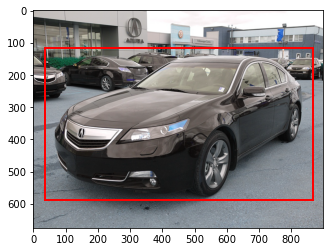

In [ ]:

fig,ax = plt.subplots(1)

ax.imshow(unscaled)
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

ax.add_patch(rect)

plt.show()

**Converting Training and Test Images to Array**

In [ ]:
for i, f in enumerate(X_train):
  img = Image.open(f)
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
  img = img.convert('RGB')

  X_train[i] = preprocess_input(np.array(img, dtype=np.float32))
  img.close()

In [ ]:
X_train = np.array(X_train)

In [ ]:
X_train.shape

(8144, 128, 128, 3)

In [ ]:
y_train

array([[  8.32      ,  37.12      , 113.06666667,  82.88      ],
       [  5.12      ,  21.99703704, 118.32888889,  89.31555556],
       [ 17.        ,  29.06666667, 103.2       ,  72.53333333],
       ...,
       [  4.43733333,  67.13859275, 108.20266667,  55.40298507],
       [  6.24      ,  63.10028116, 112.88      ,  45.82567948],
       [  2.89920725,  44.97803807, 122.05662514,  81.89751098]])

In [ ]:
y_train.shape

(8144, 4)

In [ ]:
for i, f in enumerate(X_test):
  img = Image.open(f) # Read image
  img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
  img = img.convert('RGB')

  X_test[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
  img.close()

In [ ]:
X_test = np.array(X_test)

In [ ]:
X_test.shape

(8041, 128, 128, 3)

**Modelling with MobileNet**

In [ ]:
ALPHA = 1.0
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)
    
    for layer in model.layers:
        layer.trainable = trainable

    x0 = model.layers[-1].output
    x1 = Conv2D(4, kernel_size=4, name="coords")(x0)
    x2 = Reshape((4,))(x1)
    
    return Model(inputs=model.input, outputs=x2)

In [ ]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
      if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
        intersections += intersection[j]
        unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [ ]:
def IoU(y_true, y_pred):
    iou = tensorflow.py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

In [ ]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [ ]:
model = create_model(False)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU])

In [ ]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[callback])

Epoch 1/10
255/255 [==============================] - 174s 684ms/step - loss: 203.7667 - IoU: 0.7274 - val_loss: 77.5324 - val_IoU: 0.7841
Epoch 2/10
255/255 [==============================] - 177s 695ms/step - loss: 61.7071 - IoU: 0.8111 - val_loss: 66.6011 - val_IoU: 0.8063
Epoch 3/10
255/255 [==============================] - 178s 697ms/step - loss: 48.3905 - IoU: 0.8303 - val_loss: 64.6312 - val_IoU: 0.8077
Epoch 4/10
255/255 [==============================] - 178s 698ms/step - loss: 40.3012 - IoU: 0.8426 - val_loss: 63.7707 - val_IoU: 0.8126
Epoch 5/10
255/255 [==============================] - 210s 822ms/step - loss: 34.0755 - IoU: 0.8536 - val_loss: 65.3948 - val_IoU: 0.8048
Epoch 6/10
255/255 [==============================] - 185s 725ms/step - loss: 29.3263 - IoU: 0.8636 - val_loss: 65.1419 - val_IoU: 0.8080


In [ ]:
model.evaluate(X_test, y_test)

252/252 [==============================] - 87s 345ms/step - loss: 65.1419 - IoU: 0.8080


[65.14189910888672, 0.8080042600631714]

**Testing Model with Test Images**

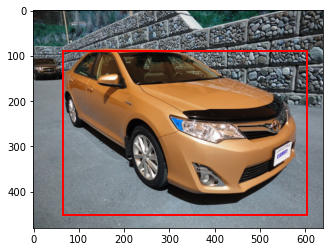

In [ ]:
filename = test_dir+'/Toyota Camry Sedan 2012/00004.jpg'

unscaled = cv.imread(filename) # Original image for display

im = Image.open(filename)
image_width, image_height = im.size

image = cv.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox


x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

**Converting all images to 224 x 244 size**

In [ ]:
def save_train_data(fnames, labels, bboxes):
    src_folder = path_base+'/car_data/car_data/train/'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    
    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2,class_id) = bboxes[i]

        src_path = src_folder +class_names[class_id-1]+ "/"
        src_path = os.path.join(src_path, fname)
        print(src_path)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
    
        if i in train_indexes:
            dst_folder = path_base+'/working/data/train/'
        else:
            dst_folder = path_base+'/working/data/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [ ]:
def save_test_data(fnames, bboxes):
    src_folder =path_base+'/car_data/car_data/test/'
    dst_folder = path_base+'/working/data/test/'
    num_samples = len(fnames)

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2,class_id) = bboxes[i]
       
        src_path = src_folder +class_names[class_id-1]+ "/"
        src_path = os.path.join(src_path, fname)
        print(src_path)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [ ]:
def process_train_data():
    with open(path_base+"/anno_train.csv", "r") as f:
        print("Processing train data...")
        data = csv.reader(f, delimiter=',')

        fnames = []
        class_ids = []
        bboxes = []
        labels = []

        for index, row in enumerate(data):
            fname, x0, y0,x1,y1, carclass = row
            bbox_x1 = int(x0)
            bbox_y1 = int(y0)
            bbox_x2 = int(x1)
            bbox_y2 = int(y1)
            class_id = int(carclass)
            labels.append('%04d' % (class_id,))
            bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2, class_id))
            class_ids.append(class_id)
            fnames.append(fname)

        labels_count = np.unique(class_ids).shape[0]
        print('The number of different cars is %d' % labels_count)

        save_train_data(fnames, labels, bboxes)

In [ ]:
def process_test_data():
    with open(path_base+"/anno_test.csv", "r") as f:
        print("Processing train data...")
        data = csv.reader(f, delimiter=',')

        fnames = []
        bboxes = []

        for index, row in enumerate(data):
            fname, x0, y0,x1,y1, carclass = row
            bbox_x1 = int(x0)
            bbox_y1 = int(y0)
            bbox_x2 = int(x1)
            bbox_y2 = int(y1)
            class_id = int(carclass)
            bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2,class_id))
            fnames.append(fname)

        save_test_data(fnames, bboxes)

In [ ]:
img_width, img_height = 224, 224

In [ ]:
process_train_data()

In [ ]:
process_test_data()

**Modelling with VGGNet**

In [ ]:
train_data = path_base+'/working/data/train'
valid_data = path_base+'/working/data/valid'

#pretrained VGG16
model_init = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=None)

#freeze all layers except last
for layer in model_init.layers[:17]:
    layer.trainable = False


#fully connected layers for learning weights (fine-tune)
x = model_init.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.7)(x)
pred = Dense(196, activation='softmax')(x)
model = Model(inputs=model_init.input, outputs=pred)

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['categorical_accuracy'])

In [ ]:
train_data_gen = ImageDataGenerator(rescale = 1./255, rotation_range = 30, width_shift_range=0.2, height_shift_range=0.2,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale = 1./255)
validation_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_data_gen.flow_from_directory(train_data, target_size =(224,224), 
                                                    batch_size = 20, class_mode='categorical')
                                                    
validation_generator = validation_data_gen.flow_from_directory(valid_data, target_size=(224,224),
                                                          batch_size = 20, class_mode='categorical')

Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
history = model.fit(train_generator,steps_per_epoch=240,epochs=60,
                              validation_data=validation_generator,validation_steps=100, shuffle = True, verbose =1)

Epoch 1/60
240/240 [==============================] - 65s 272ms/step - loss: 1.8352 - categorical_accuracy: 0.5101 - val_loss: 1.3777 - val_categorical_accuracy: 0.6335
Epoch 2/60
240/240 [==============================] - 61s 253ms/step - loss: 1.8500 - categorical_accuracy: 0.4957
Epoch 3/60
240/240 [==============================] - 61s 254ms/step - loss: 1.7997 - categorical_accuracy: 0.5205
Epoch 4/60
240/240 [==============================] - 60s 252ms/step - loss: 1.7494 - categorical_accuracy: 0.5291
Epoch 5/60
240/240 [==============================] - 61s 253ms/step - loss: 1.7163 - categorical_accuracy: 0.5316
Epoch 6/60
240/240 [==============================] - 60s 252ms/step - loss: 1.6721 - categorical_accuracy: 0.5497
Epoch 7/60
240/240 [==============================] - 61s 253ms/step - loss: 1.6478 - categorical_accuracy: 0.5479
Epoch 8/60
240/240 [==============================] - 61s 255ms/step - loss: 1.5857 - categorical_accuracy: 0.5633
Epoch 9/60
240/240 [======

In [ ]:
model.save('VGG16_cv2.h5')

In [ ]:
model.evaluate(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)  

82/82 [==============================] - 5s 57ms/step - loss: 0.9324 - categorical_accuracy: 0.7330


[0.9323628544807434, 0.7329649925231934]

In [ ]:
pred = model.predict(validation_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)  
predicted = np.argmax(pred, axis=1) 

82/82 [==============================] - 5s 57ms/step


**Validating Model Classification Accuracy with Test Images**

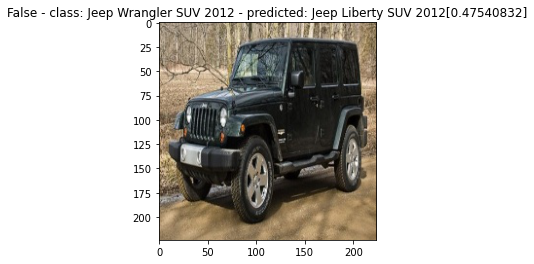

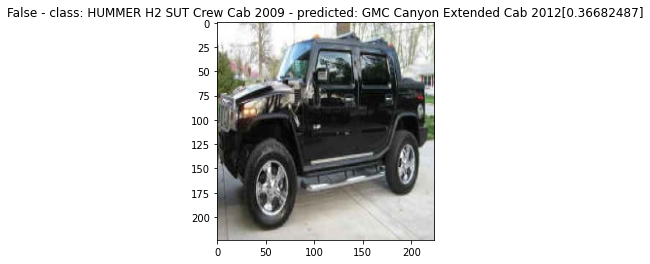

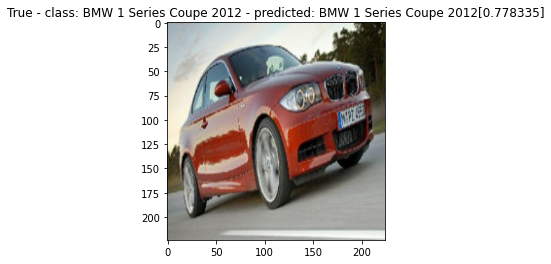

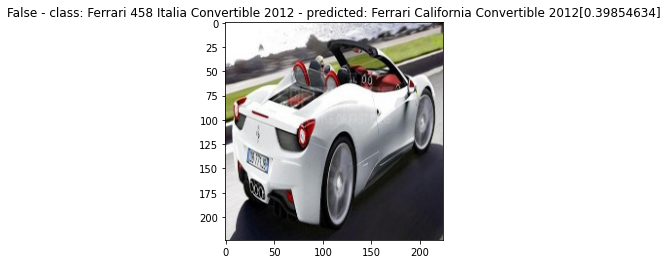

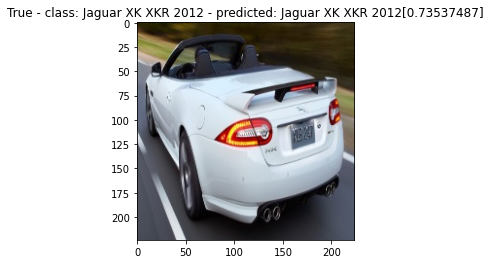

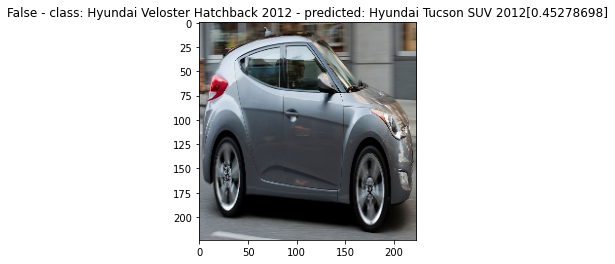

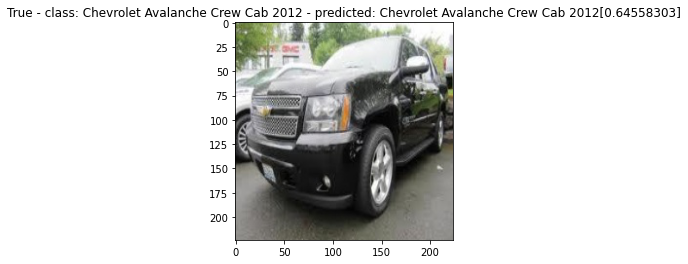

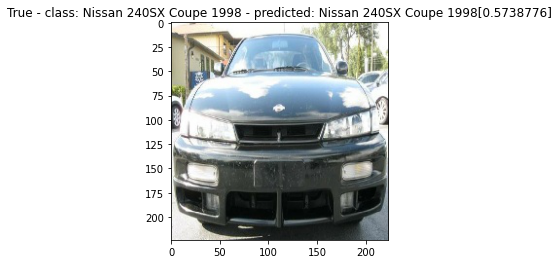

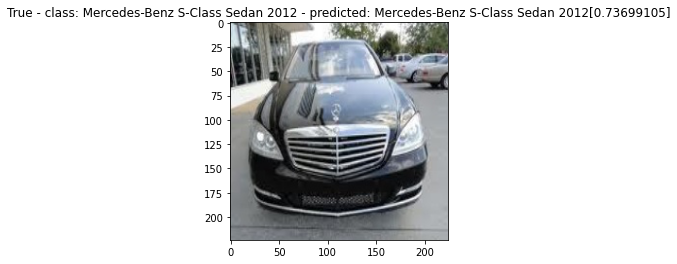

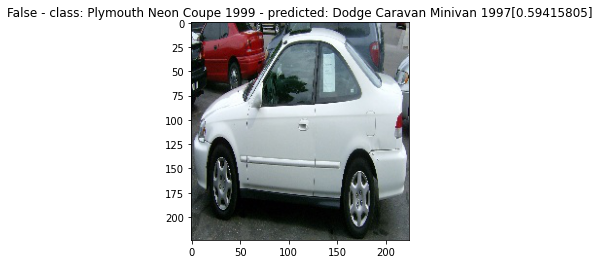

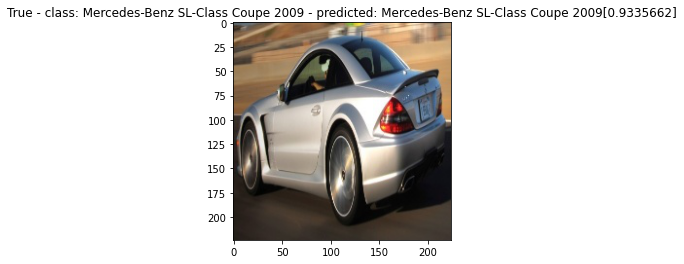

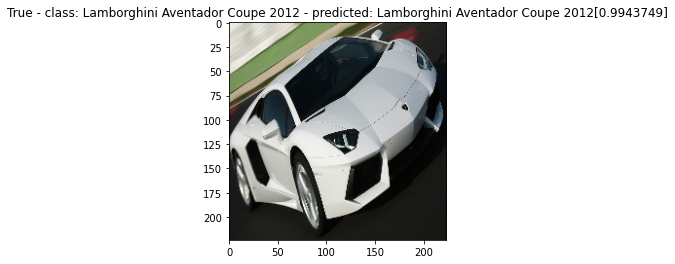

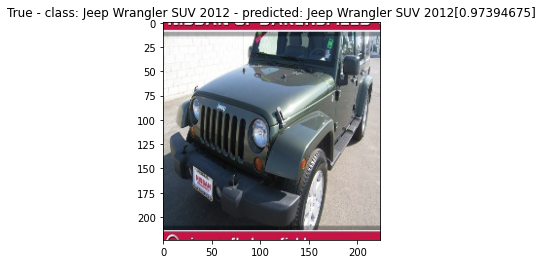

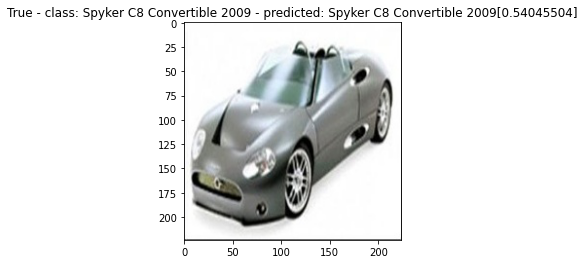

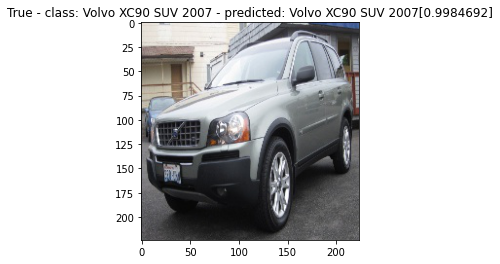

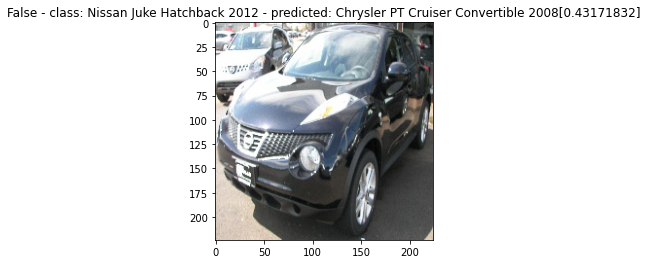

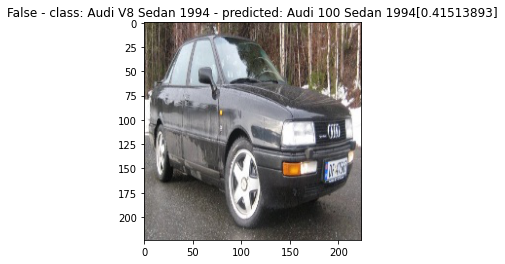

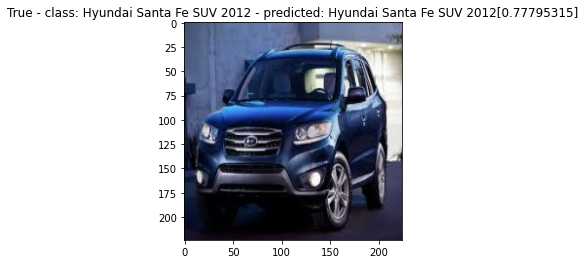

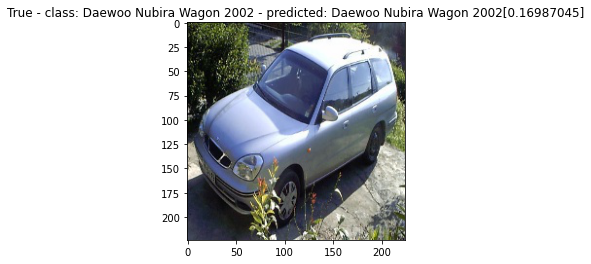

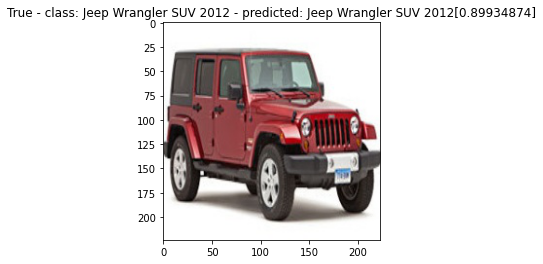

In [ ]:
def predict_one(model):  
    image_batch, classes_batch = next(validation_generator)
    predicted_batch = model.predict(image_batch)
    for k in range(0,image_batch.shape[0]):
      image = image_batch[k]
      pred = predicted_batch[k]
      the_pred = np.argmax(pred)
      predicted = class_names[the_pred]
      val_pred = max(pred)
      the_class = np.argmax(classes_batch[k])
      value = class_names[np.argmax(classes_batch[k])]
      plt.figure(k)
      isTrue = (the_pred == the_class)
      plt.title(str(isTrue) + ' - class: ' + value + ' - ' + 'predicted: ' + predicted + '[' + str(val_pred) + ']')
      plt.imshow(image)

predict_one(model)  

Based on output, the model is able to predict the car make and year with 73% accuracy. As we can see in the above images, the model is making encouraging predictions and needs to be further fine-tuned.